In [1]:
%load_ext tensorboard

In [2]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np, scipy as sp, scipy.stats, os, sys, joblib
import os, numpy as np, scipy as sp, scipy.io, scipy.io.wavfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
import random
import pandas as pd
import importlib
import datetime
import useful_functions
import preprocessing_functions
import Chatgpt_model
import results_functions
import metrics_loss_functions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
importlib.reload(Chatgpt_model)
from Chatgpt_model import *
importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *

2023-07-31 15:00:24.313606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 15:00:24.334715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 15:00:24.680747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2023-07-31 15:00:26.064820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 15:00:26.065284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 15:00:26.065339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
importlib.reload(useful_functions)
importlib.reload(preprocessing_functions)
importlib.reload(Chatgpt_model)
from useful_functions import *
from preprocessing_functions import *
from Chatgpt_model import *

In [4]:
 # Define the data and model foldes.
data_folder = r"../training_data"
model_folder = r"../model"
wind_size = 6000
verbose = 3

In [5]:
recordings,patient_label,patient_id = create_rec_patient_list(data_folder)
df = build_dataset_df(recordings,patient_id,patient_label,wind_size)
df.head()

,patient_id,recording_type,recording,murmur
0,2530.0,1.0,"[254.62053374948147, 332.41397606699405, -727....",0.0
1,2530.0,1.0,"[20.550841480663475, -18.884669077279337, 152....",0.0
2,2530.0,1.0,"[2296.0082592261, 1161.8953810714854, 106.9764...",0.0
3,2530.0,1.0,"[-1.2132347511973676, -24.042684343382245, -14...",0.0
4,2530.0,1.0,"[219.40892010033423, 106.21377642082071, 296.9...",0.0


In [6]:
# check correctness of dataframe loaded
for i in range(df.shape[0]):
  if len(df["recording"][i]) != wind_size:
    print("problem sir")

In [7]:
# select only two columns
new_df = df[['patient_id', 'murmur']]
new_df = new_df.drop_duplicates()
new_df = new_df.reset_index(drop=True)

In [8]:
# check murmur/non-murmur balance
nb_murmur_present = (new_df.loc[new_df['murmur'] == 1]).shape[0]
nb_murmur_absent = (new_df.loc[new_df['murmur'] == 0]).shape[0]
print(nb_murmur_present)
print(nb_murmur_absent)

179
695


In [9]:
# display
new_df

,patient_id,murmur
0,2530.0,0.0
1,9979.0,1.0
2,13918.0,1.0
3,14241.0,1.0
4,14998.0,0.0
...,...,...
869,85340.0,0.0
870,85341.0,0.0
871,85343.0,1.0
872,85345.0,0.0


In [10]:
# complete list of distinct patient id's and corresponding label
list_id = new_df['patient_id']
list_label = new_df['murmur']

In [11]:
id_train, id_valtest, label_train, label_valtest = train_test_split(list_id, list_label , test_size=0.4, random_state=42)
id_val, id_test, label_val, label_test = train_test_split(id_valtest, label_valtest , test_size=0.5, random_state=42)

In [12]:
def select_rows(id_list,dframe):
  #for id in list_id:
  sub_df = dframe.loc[dframe['patient_id'].isin([int(id) for id in id_list])]
  return sub_df

df_train = select_rows(id_train,df)
df_val = select_rows(id_val,df)
df_test = select_rows(id_test,df)

In [13]:
print("Number of Murmur present : ",(df_train.loc[df_train['murmur'] == 1]).shape[0])
print("Number of Murmur absent : ",(df_train.loc[df_train['murmur'] == 0]).shape[0])

Number of Murmur present :  2697
Number of Murmur absent :  11832


In [14]:
X_train = np.vstack(df_train['recording'])
y_train = np.array(df_train['murmur'])

X_val = np.vstack(df_val['recording'])
y_val = np.array(df_val['murmur'])

X_test = np.vstack(df_test['recording'])
y_test = np.array(df_test['murmur'])

In [15]:
print(type(y_val))
print(type(np.array(y_val)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
X_train = X_train.reshape(len(X_train),len(X_train[1]),1)
X_val = X_val.reshape(len(X_val),len(X_val[1]),1)
X_test = X_test.reshape(len(X_test),len(X_test[1]),1)

In [17]:
X_train.shape

(14529, 6000, 1)

In [42]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *

model = create_clique_LSTM_model(input_shape=X_train.shape[1:])


#model = make_model(input_shape=X_train.shape[1:])

In [43]:

model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 6000, 1)]            0         []                            
                                                                                                  
 conv1d_252 (Conv1D)         (None, 3000, 12)             96        ['input_7[0][0]']             
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 1500, 12)             0         ['conv1d_252[0][0]']          
 g1D)                                                                                             
                                                                                                  
 batch_normalization_376 (B  (None, 1500, 12)             48        ['max_pooling1d_6[0][0]'

                                                                                                  
 conv1d_258 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_257[0][0]']           
                                                                                                  
 concatenate_128 (Concatena  (None, 1500, 48)             0         ['max_pooling1d_6[0][0]',     
 te)                                                                 'conv1d_254[0][0]',          
                                                                     'conv1d_256[0][0]',          
                                                                     'conv1d_258[0][0]']          
                                                                                                  
 batch_normalization_385 (B  (None, 1500, 48)             192       ['concatenate_128[0][0]']     
 atchNormalization)                                                                               
          

                                                                    ]']                           
                                                                                                  
 conv1d_264 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_263[0][0]']           
                                                                                                  
 concatenate_131 (Concatena  (None, 1500, 36)             0         ['conv1d_260[0][0]',          
 te)                                                                 'conv1d_262[0][0]',          
                                                                     'conv1d_264[0][0]']          
                                                                                                  
 batch_normalization_394 (B  (None, 1500, 36)             144       ['concatenate_131[0][0]']     
 atchNormalization)                                                                               
          

 conv1d_270 (Conv1D)         (None, 1500, 12)             2604      ['re_lu_269[0][0]']           
                                                                                                  
 concatenate_134 (Concatena  (None, 1500, 36)             0         ['conv1d_266[0][0]',          
 te)                                                                 'conv1d_268[0][0]',          
                                                                     'conv1d_270[0][0]']          
                                                                                                  
 batch_normalization_403 (B  (None, 1500, 36)             144       ['concatenate_134[0][0]']     
 atchNormalization)                                                                               
                                                                                                  
 conv1d_271 (Conv1D)         (None, 1500, 216)            7992      ['batch_normalization_403[0][0
          

In [22]:
weights = class_weight.compute_class_weight(  class_weight ='balanced',
                                    classes = np.unique(y_train),
                                    y = y_train)
class_weights = dict(zip(np.unique(y_train), weights))
class_weights
wghts = {0: 0.6139705882352942, 1: 2.693548387096774}

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
weights

array([0.61397059, 2.69354839])

In [24]:
importlib.reload(results_functions)
from results_functions import *

In [25]:
fscore = tf.keras.metrics.FBetaScore(beta=2.0,threshold=0.5, average='weighted')
auc = tf.keras.metrics.AUC(name='auc',curve='PR')

In [44]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *
importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *

epochs = 100
batch_size = 32

dir_path = "checkpoint_dir/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


for i in range(1):
    checkpoint_path = dir_path + "Clique_LSTM_maxpool_patience25/"+"M_"+str(i)+"_cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)



    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1,restore_best_weights=True,mode='min'),
        tensorboard_callback,
        #custom_validation_loss,
    ]

    model = create_clique_LSTM_model(input_shape=X_train.shape[1:])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=weighted_bincrossentropy,
        metrics=[fscore,auc],
        weighted_metrics = 'acc' ,
    )


    history = model.fit(
        X_train,
        np.array(y_train),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val,np.array(y_val)),
        verbose=1,
        #class_weight = class_weights,
    )

    model.save_weights(dir_path + "Clique_LSTM_maxpool_patience25/"+"M_"+str(i)+"_restored_weight"+"_cp.ckpt")



Epoch 1/100
454/455 [============================>.] - ETA: 0s - loss: 0.6113 - fbeta_score: 0.5451 - auc: 0.5085 - acc: 0.7011
Epoch 1: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 68s 127ms/step - loss: 0.6113 - fbeta_score: 0.5451 - auc: 0.5085 - acc: 0.7011 - val_loss: 0.9621 - val_fbeta_score: 0.0329 - val_auc: 0.3830 - val_acc: 0.7846 - lr: 0.0010
Epoch 2/100
454/455 [============================>.] - ETA: 0s - loss: 0.5736 - fbeta_score: 0.5545 - auc: 0.5163 - acc: 0.7578
Epoch 2: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 57s 126ms/step - loss: 0.5737 - fbeta_score: 0.5543 - auc: 0.5162 - acc: 0.7577 - val_loss: 0.6249 - val_fbeta_score: 0.5899 - val_auc: 0.5497 - val_acc: 0.6529 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 0.5677 - fbeta_score: 0.5634 - auc: 0.5340 

455/455 [==============================] - 58s 127ms/step - loss: 0.5431 - fbeta_score: 0.5928 - auc: 0.5741 - acc: 0.7615 - val_loss: 0.5585 - val_fbeta_score: 0.6368 - val_auc: 0.6801 - val_acc: 0.6975 - lr: 0.0010
Epoch 20/100
454/455 [============================>.] - ETA: 0s - loss: 0.4769 - fbeta_score: 0.6533 - auc: 0.6803 - acc: 0.7969
Epoch 20: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 57s 126ms/step - loss: 0.4769 - fbeta_score: 0.6533 - auc: 0.6803 - acc: 0.7970 - val_loss: 0.5415 - val_fbeta_score: 0.6198 - val_auc: 0.7472 - val_acc: 0.8569 - lr: 0.0010
Epoch 21/100
454/455 [============================>.] - ETA: 0s - loss: 0.4235 - fbeta_score: 0.6944 - auc: 0.7502 - acc: 0.8304
Epoch 21: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 57s 126ms/step - loss: 0.4237 - fbeta_score: 0.6942 - auc: 0.7500 -

Epoch 38/100
454/455 [============================>.] - ETA: 0s - loss: 0.2830 - fbeta_score: 0.8039 - auc: 0.8638 - acc: 0.8828
Epoch 38: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 57s 126ms/step - loss: 0.2830 - fbeta_score: 0.8039 - auc: 0.8638 - acc: 0.8828 - val_loss: 0.6788 - val_fbeta_score: 0.6428 - val_auc: 0.7453 - val_acc: 0.8495 - lr: 5.0000e-04
Epoch 39/100
454/455 [============================>.] - ETA: 0s - loss: 0.2763 - fbeta_score: 0.8150 - auc: 0.8682 - acc: 0.8915
Epoch 39: saving model to checkpoint_dir/20230731-155349Clique_LSTM_maxpool_patience25/M_0_cp.ckpt
455/455 [==============================] - 57s 126ms/step - loss: 0.2766 - fbeta_score: 0.8147 - auc: 0.8680 - acc: 0.8915 - val_loss: 0.6860 - val_fbeta_score: 0.6416 - val_auc: 0.7388 - val_acc: 0.8294 - lr: 5.0000e-04
Epoch 40/100
454/455 [============================>.] - ETA: 0s - loss: 0.2745 - fbeta_score: 0.8141 -

In [25]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *
importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *

epochs = 100
batch_size = 32

dir_path = "checkpoint_dir/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


for i in range(5):
    checkpoint_path = dir_path + "new_loss_patience25_compress12_dropout01/"+"M_"+str(0)+"_cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    checkpoint_dir = os.path.dirname(checkpoint_path)



    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1,restore_best_weights=True,mode='min'),
        tensorboard_callback,
        #custom_validation_loss,
    ]

    model = create_small_model(input_shape=X_train.shape[1:])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=weighted_bincrossentropy,
        metrics=[fscore,auc],
        weighted_metrics = 'acc' ,
    )


    history = model.fit(
        X_train,
        np.array(y_train),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_val,np.array(y_val)),
        verbose=0,
        #class_weight = class_weights,
    )

    model.save_weights(dir_path + "new_loss_patience25_compress12_dropout01/"+"M_"+str(0)+"_restored_weight"+"_cp.ckpt")




Epoch 1: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 2: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 3: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 4: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 5: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 6: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 7: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 8: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 9: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 10: saving m


Epoch 19: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 20: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 21: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 22: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 23: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 24: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 25: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 26: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 27: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 28:


Epoch 6: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 7: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 8: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 9: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt

Epoch 10: saving model to checkpoint_dir/20230728-070619new_loss_patience25_compress12_dropout01/M_0_cp.ckpt


KeyboardInterrupt: 

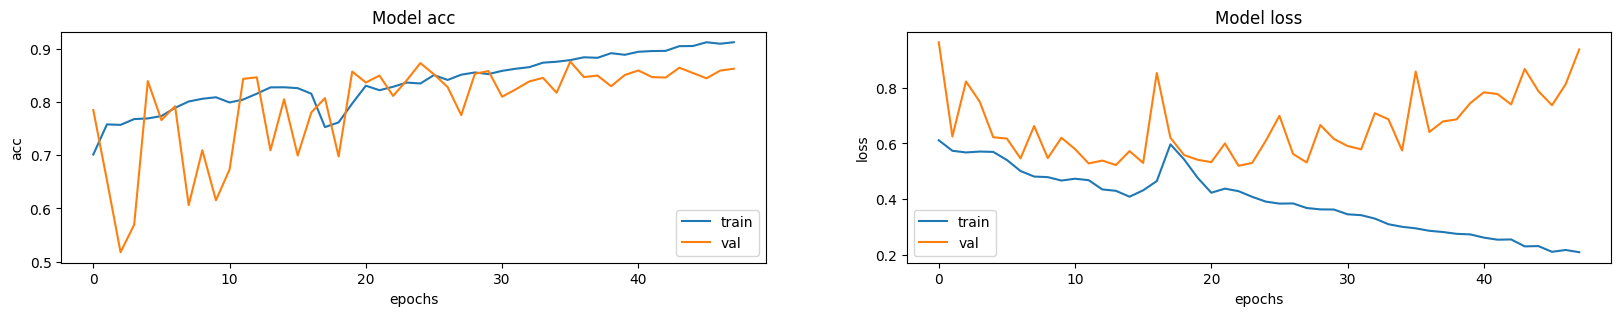

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    


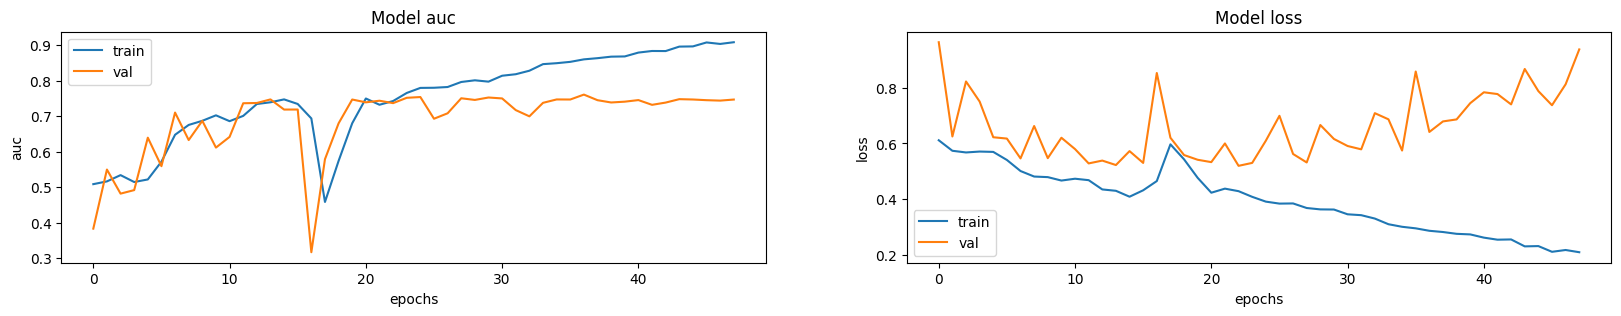

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [71]:
model.load_weights("checkpoint_dir/20230727-165208LSTM_test_patience15_compress12_dropout02_aftermerge_i/M_0_cp.ckpt")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_bincrossentropy,
    metrics=[auc],
    weighted_metrics = 'acc' ,
)
checkpoint_path = "checkpoint_dir/20230727-165208LSTM_test_patience15_compress12_dropout02_aftermerge_i_continue/M_0_cp.ckpt"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1,restore_best_weights=True,mode='min'),
    #tensorboard_callback,
    #custom_validation_loss,
]

history = model.fit(
    X_train,
    np.array(y_train),
    batch_size=32,
    epochs=73,
    callbacks=callbacks,
    validation_data=(X_val,np.array(y_val)),
    verbose=1,
    #class_weight = class_weights,
)

model.save_weights("checkpoint_dir/20230727-165208LSTM_test_patience15_compress12_dropout02_aftermerge_i_continue/M_0_restored_weight_cp.ckpt")



Epoch 1/73
454/455 [============================>.] - ETA: 0s - loss: 0.3277 - auc: 0.7994 - acc: 0.8630
Epoch 1: saving model to checkpoint_dir/20230727-165208LSTM_test_patience15_compress12_dropout02_aftermerge_i_continue/M_0_cp.ckpt
455/455 [==============================] - 110s 180ms/step - loss: 0.3277 - auc: 0.7994 - acc: 0.8630 - val_loss: 0.6807 - val_auc: 0.7415 - val_acc: 0.8600 - lr: 5.0000e-04
Epoch 2/73
455/455 [==============================] - ETA: 0s - loss: 0.3335 - auc: 0.8160 - acc: 0.8606
Epoch 2: saving model to checkpoint_dir/20230727-165208LSTM_test_patience15_compress12_dropout02_aftermerge_i_continue/M_0_cp.ckpt
455/455 [==============================] - 81s 178ms/step - loss: 0.3335 - auc: 0.8160 - acc: 0.8606 - val_loss: 0.6485 - val_auc: 0.7393 - val_acc: 0.8453 - lr: 5.0000e-04
Epoch 3/73
454/455 [============================>.] - ETA: 0s - loss: 0.3248 - auc: 0.8267 - acc: 0.8594
Epoch 3: saving model to checkpoint_dir/20230727-165208LSTM_test_patience15_

KeyboardInterrupt: 

In [47]:
model.evaluate(X_test, y_test) 

152/152 [==============================] - 4s 26ms/step - loss: 0.5423 - fbeta_score: 0.6326 - auc: 0.7148 - acc: 0.7944


[0.5422962307929993,
 0.6325515508651733,
 0.7147872447967529,
 0.7944079041481018]

In [48]:
pred = model.predict(X_test)
print(pred)

152/152 [==============================] - 4s 24ms/step
[[0.57153803]
 [0.3536995 ]
 [0.12283016]
 ...
 [0.06724702]
 [0.16473596]
 [0.18583317]]


In [26]:
importlib.reload(Chatgpt_model)
from Chatgpt_model import *
importlib.reload(metrics_loss_functions)
from metrics_loss_functions import *

model6 = create_small_model_6(input_shape=X_train.shape[1:])
model6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[auc],
    weighted_metrics = 'acc' ,
)
model12 = create_small_model(input_shape=X_train.shape[1:])
model12.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[auc],
    weighted_metrics = 'acc' ,
)




In [27]:

paths=[]
paths.append("checkpoint_dir/20230728-020158new_loss_patience25_compress6_dropout01/M_0_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230728-101829new_loss_patience25_compress6_dropout01/M_0_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230728-114213new_loss_patience25_compress6_dropout01/M_0_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230728-114213new_loss_patience25_compress6_dropout01/M_1_restored_weight_cp.ckpt")
paths.append("checkpoint_dir/20230728-114213new_loss_patience25_compress6_dropout01/M_2_restored_weight_cp.ckpt")

preds=[]



for i in range(len(paths)):
    model6.load_weights(paths[i])    
    print("Résultats modèle ",i," : ")
    model6.evaluate(X_val,y_val)
    model6.evaluate(X_test,y_test)
    preds.append(model6.predict(X_test,verbose=0))
"""    
    if i==1:
        model12.load_weights(paths[i])    
        print("Résultats modèle ",i," : ")
        model12.evaluate(X_val,y_val)
        model12.evaluate(X_test,y_test)
        preds.append(model12.predict(X_test,verbose=0))
"""

Résultats modèle  0  : 
152/152 [==============================] - 4s 24ms/step - loss: 0.4704 - auc: 0.7230 - acc: 0.8104
Résultats modèle  1  : 
152/152 [==============================] - 4s 26ms/step - loss: 0.4191 - auc: 0.7220 - acc: 0.8150
Résultats modèle  2  : 
152/152 [==============================] - 4s 25ms/step - loss: 0.4618 - auc: 0.6884 - acc: 0.7864
Résultats modèle  3  : 
152/152 [==============================] - 4s 23ms/step - loss: 0.5319 - auc: 0.7171 - acc: 0.7325
Résultats modèle  4  : 
152/152 [==============================] - 3s 23ms/step - loss: 0.4916 - auc: 0.6936 - acc: 0.7745


'    \n    if i==1:\n        model12.load_weights(paths[i])    \n        print("Résultats modèle ",i," : ")\n        model12.evaluate(X_val,y_val)\n        model12.evaluate(X_test,y_test)\n        preds.append(model12.predict(X_test,verbose=0))\n'

In [56]:
importlib.reload(results_functions)
from results_functions import *

n=4
pred=preds[n]
"""
pred_0 = get_patients_pred(preds[0],df_test)
pred_1 = get_patients_pred(preds[1],df_test)
pred_2 = get_patients_pred(preds[2],df_test)
pred_3 = get_patients_pred(preds[3],df_test)
pred_4 = get_patients_pred(preds[4],df_test)

pred_0 = (preds[0] > 0.5)*1
pred_1 = (preds[1] > 0.5)*1
pred_2 = (preds[2] > 0.5)*1
pred_3 = (preds[3] > 0.5)*1
pred_4 = (preds[4] > 0.5)*1

pred = np.add(pred_0, pred_1,pred_2)
pred = np.add(pred,pred_3,pred_4)
pred = pred/5
"""
#pred = (pred > 0.5)*1

'\npred_0 = get_patients_pred(preds[0],df_test)\npred_1 = get_patients_pred(preds[1],df_test)\npred_2 = get_patients_pred(preds[2],df_test)\npred_3 = get_patients_pred(preds[3],df_test)\npred_4 = get_patients_pred(preds[4],df_test)\n\npred_0 = (preds[0] > 0.5)*1\npred_1 = (preds[1] > 0.5)*1\npred_2 = (preds[2] > 0.5)*1\npred_3 = (preds[3] > 0.5)*1\npred_4 = (preds[4] > 0.5)*1\n\npred = np.add(pred_0, pred_1,pred_2)\npred = np.add(pred,pred_3,pred_4)\npred = pred/5\n'

In [49]:
list_patient_rows = list(df_test.groupby(['patient_id'])['patient_id'].count())

In [50]:
pred_groupby_patient = np.split(pred,cumulative(list_patient_rows))
pred_groupby_patient = pred_groupby_patient[:-1]

df_test = df_test.astype({'murmur':'int'})
y_test_grouped = df_test[['patient_id','murmur']].drop_duplicates()['murmur'].to_list()

In [51]:
pred1 = mean_pred(pred_groupby_patient)
pred2 = majority_pred(pred_groupby_patient)

In [52]:
print(pred1)
#print(pred2)
#print(y_test_grouped)
y_true = pred2
y_pred = y_test_grouped
# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
weight_positive = 5
weight_negative = 1
weighted_accuracy = (weight_positive * tp + weight_negative * tn) / (weight_positive * (tp + fn) + weight_negative * (tn + fp))


print("Accuracy score of mean_pred : ",accuracy_score(pred1 , y_test_grouped))
print("Accuracy score of majority_pred : ",accuracy_score(pred2 , y_test_grouped))
#print("Weighted accuracy score of majority_pred : ",balanced_accuracy_score(pred2 , y_test_grouped))
print("Weighted accuracy score of majority_pred : ",weighted_accuracy)

[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Accuracy score of mean_pred :  0.8742857142857143
Accuracy score of majority_pred :  0.8571428571428571
Weighted accuracy score of majority_pred :  0.8063492063492064


In [53]:
a = 0.814 + 0.91 + 0.814 + 0.733 + 0.778
a/5

0.8097999999999999

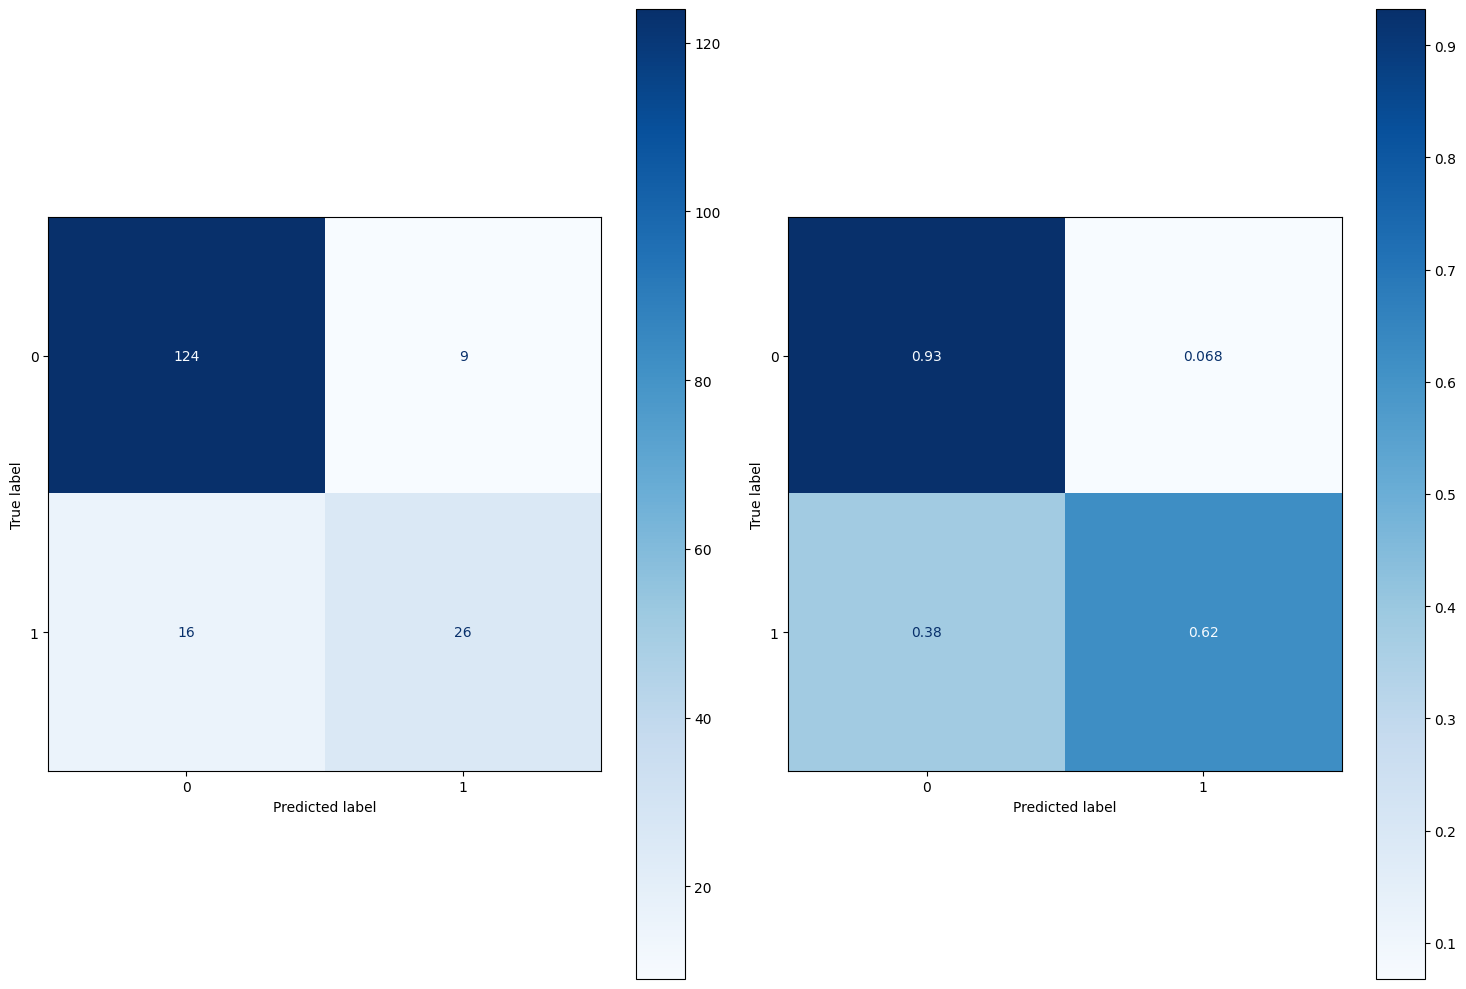

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))


ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,ax=axes[0],
                                        cmap='Blues', normalize = None)

ConfusionMatrixDisplay.from_predictions(y_test_grouped, pred2,ax=axes[1],
                                        cmap='Blues', normalize = 'true')

plt.tight_layout()  
plt.show()

In [55]:
def compute_confusion_matrix(labels, outputs):
    assert(np.shape(labels)[0] == np.shape(outputs)[0])
    assert(all(value in (0, 1, True, False) for value in np.unique(labels)))
    assert(all(value in (0, 1, True, False) for value in np.unique(outputs)))

    num_patients = np.shape(labels)[0]
    num_label_classes = np.shape(labels)[1]
    num_output_classes = np.shape(outputs)[1]

    A = np.zeros((num_output_classes, num_label_classes))
    for k in range(num_patients):
        for i in range(num_output_classes):
            for j in range(num_label_classes):
                if outputs[k, i] == 1 and labels[k, j] == 1:
                    A[i, j] += 1

    return A

In [56]:
from sklearn.preprocessing import LabelBinarizer

def reshape_binary(bin_list):
    labels = bin_list  # your binary labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    # If your labels are all 0's and 1's, then `LabelBinarizer` will output a 2D array with one column.
    # Since your function expects labels for both classes, you need to add the second column manually.
    if labels.shape[1] == 1:
        labels = np.hstack((1 - labels, labels))  # add second column as the negation of the first column
    return labels

resh_labels = reshape_binary(y_true)
resh_pred = reshape_binary(y_pred)
compute_confusion_matrix(resh_labels, resh_pred)

array([[124.,   9.],
       [ 16.,  26.]])

In [41]:
def compute_weighted_accuracy(labels, outputs):
    
    weights = np.array([[1,5], [1,5]])
    # Compute confusion matrix.
    assert(np.shape(labels) == np.shape(outputs))
    A = compute_confusion_matrix(labels, outputs)

    # Multiply the confusion matrix by the weight matrix.
    assert(np.shape(A) == np.shape(weights))
    B = weights * A

    # Compute weighted_accuracy.
    if np.sum(B) > 0:
        weighted_accuracy = np.trace(B) / np.sum(B)
    else:
        weighted_accuracy = float('nan')

    return weighted_accuracy

In [62]:
compute_weighted_accuracy(resh_labels, resh_pred)

0.8176638176638177